## Part 2 : feature detection

We are going to look at the following feature detector :

- Harris corner detection

In [1]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color
from scipy import signal
from scipy.ndimage.morphology import binary_dilation

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

# this function annotates an image with coloured squares at the positions detected by the harris detector
def annotate_image(img_in, img_harris):
    
    img_harris_out = np.tile( np.expand_dims(img_in,axis=2), (1,1,3))
    block_size = 5
    struct_el = np.ones((block_size,block_size))
    # now annotate the image
    img_harris = binary_dilation(img_harris,struct_el)
    img_harris_out[img_harris>0,0] = 1.0
    img_harris_out[img_harris>0,1:3] = 0.0
    
        
    return img_harris_out


file_dir = 'images/'
file_name = 'mit'
file_ext = '.png'
img_gray,_ = read_image(file_dir+file_name+file_ext)
display_image(img_gray)
img_gray.shape

(600, 800)

The goal of the Harris detector is to detect corners. The criterion used is the following : if we shift the image (spatially) in any direction, the underlying image should change values. In other words, we should be able to distinguish between the initial image and the shifted image. This is not true, for example, with constant images or edges; there is an ambiguity (see the lesson slides for more detail).

This criterion is formalised by associating the following matrix with __each pixel__ $p$ in the image :

$A = 
    \begin{bmatrix}
        \sum_{q \in \Psi_p} I_x(q)^2 & \sum_{q \in \Psi_p} I_x(q)I_y(q) \\
        \sum_{q \in \Psi_p} I_x(q)I_y(q) & \sum_{q \in \Psi_p} I_y(q)^2
    \end{bmatrix}
$

where $I_x$ is the $x$-direction component of image gradient, and similarly for $I_y$, and $\Psi_p$ is a small ''patch'' centred on $p$. A patch is a small image square.

Each pixel, therefore, contains a descriptor. The Harris detector consists in detecting the pixels whose descriptor verifies the following criterion :

$| \text{det}(A) - \alpha \text{trace}(A)^2 |  >k$

where det refers to the determinant of the matrix, and $k$ is a threshold. If this criterion is verified, then both the eigenvalues of the matrix are very large, which means that the two principal directions of local motion in the image lead to large changes in the image (which is what we were looking for). In fact, this does not correspond to __only__ corners, however corners do verify this criterion. 

For more precise details about this, again, see the slides.

We are going to implement this detector now.

Firstly, implement a function ``harris_feature`` which calculates the previous criterion for each pixel. You will have to implement the following steps :

- calculate the necessar gradients (you can use the ``np.gradient`` function) 
- create a filter to calculate the average value of the different gradients in a patch region. You should calculate these averages __before__ carrying out the two loops over the pixels, to avoid inefficient computation
- for each pixel, create the matrix $A$ and determine the Harris feature. For the matrix operations, you can use the ``np.linalg`` subpackage
- threshold the resulting image


Use the following parameters :

- patch_size = 7
- $\alpha$ = 0.04
- $k$ = 0.0002

In [1]:
from scipy.signal import convolve2d

def harris_feature(img,k):
    patch_size = 7
    alpha = 0.04
    A = [[0,0], [0,0]]
    dy, dx = np.gradient(img)
    
    patch = np.ones((7,7))/49 # average patch to convolve with
    
    #Convolution
    Ixx = convolve2d(dx**2, patch)
    Iyy = convolve2d(dy**2, patch)
    Ixy = convolve2d(dx * dy, patch)
    
    img_height = img.shape[0]
    img_width = img.shape[1]
    #Border control
    offset = int(patch_size/2)
    
    img_harris_detect = np.copy(img)
    harris_feature_tab = np.array((img.shape[0], img.shape[1]))
    
    #Calcul de tous les harris features
    for y in range(0, img_height):
        for x in range(0, img_width):  
            # Calculation of the A matrix with the average convolution
            A[0][0] = Ixx[y,x]
            A[0][1] = Ixy[y,x]
            A[1][0] = Ixy[y,x]
            A[1][1] = Iyy[y,x]
            
            #Calculation of the Harris feature
            det = np.linalg.det(A)
            trace = np.trace(A)
            harris_feature = det - alpha * (trace**2)
            
            if harris_feature > k:
                img_harris_detect[y,x] = 1.0
            else:
                img_harris_detect[y,x] = 0.0
                
    return img_harris_detect
  
#Stocker valeur harris feature
#Appliquer le maximum sur les points que tu detectes

Now, display the resulting image. You can use the function ``annotate_image``. Note, this outputs and RGB image, where the detected points are annotated as blocks of a certain size (5 here), in red. To display this image, you need to put the pixel values back to the range $0, \dots, 255$

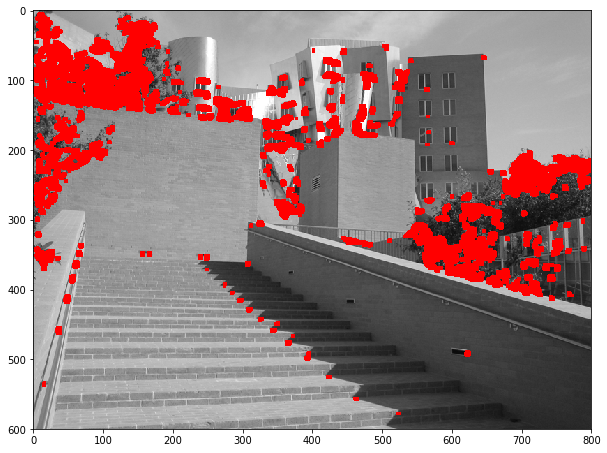

In [3]:
k = 0.00002
img_harris = harris_feature(img_gray,k)
display_image(255.0*annotate_image(img_gray,img_harris))

Now, you should observe something here: regions with many detections. Therefore, there is a second step : __non-maximum suppression__. This simply corresponds to removing detected pixels for which the Harris feature is not the maximum in a certain region.

Copy and paste the ``harris_feature`` code, and include non-maximum suppression before the output. For this, the following function can be useful:

- scipy.ndimage.maximum_filter()

In [13]:
from scipy.signal import convolve2d
from scipy.ndimage import maximum_filter

def harris_feature(img,k):
    patch_size = 7
    alpha = 0.04
    A = [[0,0], [0,0]]
    dy, dx = np.gradient(img)
    
    patch = np.ones((7,7))/49
    
    Ixx = convolve2d(dx**2, patch)
    Iyy = convolve2d(dy**2, patch)
    Ixy = convolve2d(dx * dy, patch)
    
    img_height = img.shape[0]
    img_width = img.shape[1]
    offset = int(patch_size/2)
    
    img_harris_detect = np.copy(img)
    tab_harris = np.empty((img.shape[0], img.shape[1]))
   # print(tab_harris)
    #Calcul de tous les harris features
    for y in range(0, img_height):
        for x in range(0, img_width):  
            # Calculation of the matrix A 
  
            A[0][0] = Ixx[y,x]
            A[0][1] = Ixy[y,x]
            A[1][0] = Ixy[y,x]
            A[1][1] = Iyy[y,x]
            
            #Calculation of the Harris feature
            det = np.linalg.det(A)
            trace = np.trace(A)
            harris_feature = det - alpha * (trace**2)
            
            #Using this tab, we will store the harris features describing each coordinate
            tab_harris[y][x] = harris_feature
        
    #Taking the maximum filter
    a = maximum_filter(tab_harris, size = 7)
         
    #Comparing each pixels thanks to their harris features, we select only the coordinate that have the
    # Maximum harris feature computed thanks to maximum_filter above
    for y in range(0, img_height):
        for x in range(0, img_width):
            if tab_harris[y][x] > k: #If above the threshold
                if tab_harris[y][x] == a[y][x]: # If the maximum
                    img_harris_detect[y,x] = 1.0
                else:
                    img_harris_detect[y,x] = 0.0 
                
            else:
                img_harris_detect[y,x] = 0.0
            
    print(img_harris_detect)     
    return img_harris_detect
  
#Stocker valeur harris feature
#Appliquer le maximum sur les points que tu detectes

Carry out the algorithm and display the result

[[-2.34542478e-13  6.66950375e-12  8.31784930e-12 ...  9.91102126e-12
   1.60513455e-11  4.66243096e-11]
 [ 2.38757249e-12  1.60750853e-11  2.70912403e-11 ...  4.73872006e-11
   5.48892785e-11  1.05985641e-10]
 [ 2.52324944e-12  1.85640912e-11  8.81740968e-11 ...  7.24292616e-11
   7.42581686e-11  1.37537386e-10]
 ...
 [ 5.41297208e-12  1.34806432e-11  2.63760701e-11 ...  1.89995009e-10
   2.07473517e-10  3.33722103e-10]
 [ 2.64257115e-12  9.70906826e-12  2.36548538e-11 ...  2.85405560e-10
   2.96271732e-10  4.36931569e-10]
 [ 1.49102961e-11  7.16368194e-11  1.40939693e-10 ...  4.47735178e-10
   6.26373096e-10  1.03455852e-09]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


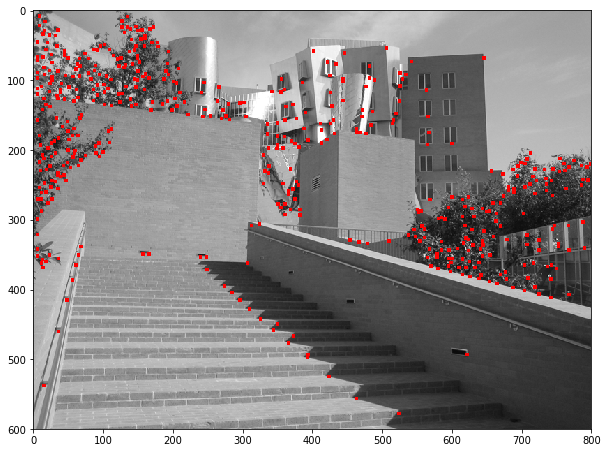

In [14]:
k = 0.00002
img_harris = harris_feature(img_gray,k)
display_image(255.0*annotate_image(img_gray,img_harris))

__Question__ Are there any corners missed ? Why do you think this is ? What solution could you propose (which we have seen in the first lesson) to improve the result.

__Answer__ Some corners are missed in the back, especially where the sky meets the top of the buidlings. As harris feature uses the pictures' gradient to compare the pixels and thus, find the corners, I suggest that we increase the picture contrast in order to allow the corner to be easily detected.